In [30]:
!pip install -q imdb-sqlite


In [31]:
!pip install -q pycountry

In [32]:
%%time
!imdb-sqlite

2021-08-07 17:37:44,383 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 10.2 ms, sys: 10.5 ms, total: 20.8 ms
Wall time: 299 ms


In [33]:
import re # expressoes regulares
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # datavis
from matplotlib import cm # datavis
from sklearn.feature_extraction.text import CountVectorizer
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style = 'whitegrid')

In [34]:
conn = sqlite3.connect('imdb.db')

In [35]:
tabelas = pd.read_sql_query("SELECT name AS 'table_name' FROM sqlite_master WHERE type = 'table'",conn)

In [36]:
type(tabelas)

pandas.core.frame.DataFrame

In [37]:
tabelas.head()

,table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [38]:
tabelas = tabelas["table_name"].values.tolist()

In [39]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print('Esquema da tabela: ',tabela)
    display(resultado)
    print('-'*100 + '\n')

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------



# 1 - Quais são as categorias de filmes mais comuns
## Quais são os principais tipos (categorias) dos títulos (filmes)?

In [40]:
consulta1 = '''SELECT type, count(*) as cont from titles group by type'''
resultado1 = pd.read_sql_query(consulta1,conn)
display(resultado1)

,type,cont
0,movie,584245
1,radioEpisode,1
2,radioSeries,1
3,short,824167
4,tvEpisode,5963818
5,tvMiniSeries,38662
6,tvMovie,132412
7,tvSeries,212057
8,tvShort,10163
9,tvSpecial,33584


In [41]:
resultado1['%'] = (resultado1['cont'] / resultado1['cont'].sum()) * 100
display(resultado1)

,type,cont,%
0,movie,584245,7.173581
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,824167,10.119434
4,tvEpisode,5963818,73.226014
5,tvMiniSeries,38662,0.474707
6,tvMovie,132412,1.625805
7,tvSeries,212057,2.603716
8,tvShort,10163,0.124785
9,tvSpecial,33584,0.412357


In [42]:
outros = {}
outros['cont'] = resultado1[resultado1['%'] < 5]['cont'].sum()
outros['%'] = resultado1[resultado1['%'] < 5]['%'].sum()
outros['type'] = 'outros'
outros

{'cont': 772168, '%': 9.480970846464036, 'type': 'outros'}

In [43]:
resultado1 = resultado1[resultado1['%'] > 5]
resultado1 = resultado1.append(outros,ignore_index = True)
resultado1 = resultado1.sort_values(by = 'cont', ascending = False)
display(resultado1)

,type,cont,%
2,tvEpisode,5963818,73.226014
1,short,824167,10.119434
3,outros,772168,9.480971
0,movie,584245,7.173581


In [44]:
rotulos = [str(resultado1['type'][i]) +': '+ str(round(resultado1['%'][i],2)) + '%' for i in resultado1.index]

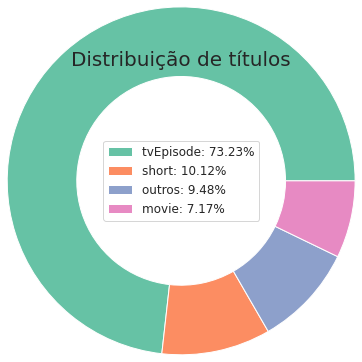

In [45]:
cs = cm.Set2(np.arange(100))
f = plt.figure()
plt.pie(resultado1['cont'],labeldistance = 1, radius = 2, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = rotulos, loc = 'center', prop = {'size': 12})
plt.title('Distribuição de títulos', loc = 'center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

# Qual o número de títulos por gênero?

In [46]:
consulta2 = '''SELECT genres, count(*) FROM titles WHERE type = 'movie' GROUP BY genres'''
resultado2 = pd.read_sql_query(consulta2,conn)
display(resultado2)

,genres,count(*)
0,Action,13304
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1439,"Thriller,Western",39
1440,War,1248
1441,"War,Western",9
1442,Western,4024


In [47]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [48]:
temp = resultado2['genres'].dropna()

In [49]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [50]:
generos = vetor.transform(temp)
type(generos)

scipy.sparse.csr.csr_matrix

In [51]:
generosUnicos = vetor.get_feature_names()
generos = pd.DataFrame(generos.todense(),columns = generosUnicos, index = temp.index)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1443
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1444 non-null   int64
 1   adult        1444 non-null   int64
 2   adventure    1444 non-null   int64
 3   animation    1444 non-null   int64
 4   biography    1444 non-null   int64
 5   comedy       1444 non-null   int64
 6   crime        1444 non-null   int64
 7   documentary  1444 non-null   int64
 8   drama        1444 non-null   int64
 9   family       1444 non-null   int64
 10  fantasy      1444 non-null   int64
 11  film-noir    1444 non-null   int64
 12  game-show    1444 non-null   int64
 13  history      1444 non-null   int64
 14  horror       1444 non-null   int64
 15  music        1444 non-null   int64
 16  musical      1444 non-null   int64
 17  mystery      1444 non-null   int64
 18  n            1444 non-null   int64
 19  news         1444 non-null   int64
 20  reality-

In [52]:
generos = generos.drop(columns = 'n', axis = 0)

In [53]:
generosPercentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]
generosPercentual.head(10)

drama          18.421053
comedy         16.828255
documentary    15.997230
adventure      14.889197
action         14.612188
romance        13.504155
crime          13.019391
mystery        12.603878
thriller       12.396122
fantasy        12.257618
dtype: float64

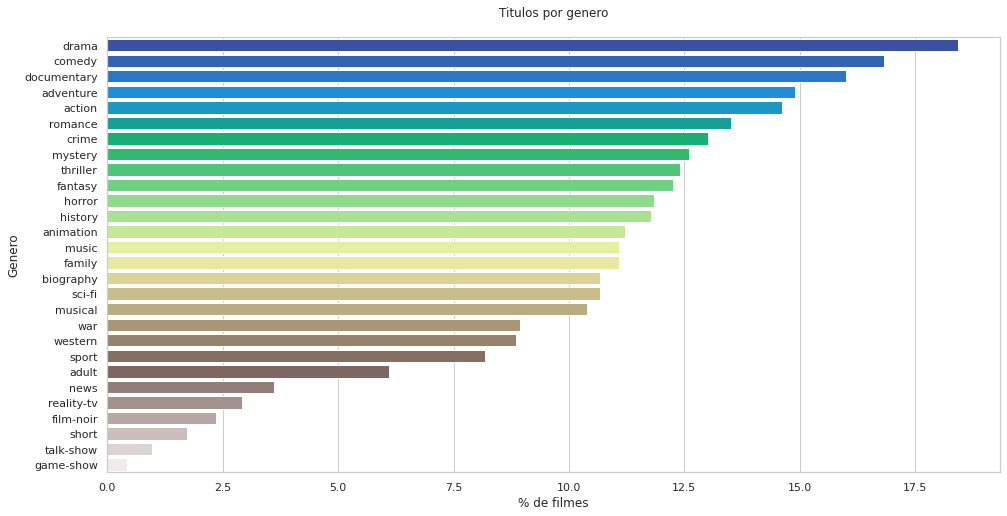

In [27]:
plt.figure(figsize = (16,8))
sns.barplot(x = generosPercentual.values, y = generosPercentual.index, orient = 'h', palette = 'terrain')
plt.ylabel('Genero')
plt.xlabel('% de filmes')
plt.title('Titulos por genero\n')
plt.show()

# Qual a mediana de avaliação dos filmes por gênero

A mediana não é afetada por outliers como a média.

In [28]:
consulta3 = '''
select
    rating
    , genres 
from 
    ratings
    join titles on ratings.title_id = titles.title_id
where
    premiered <= 2022
    and type = 'movie'
'''

In [29]:
resultado3 = pd.read_sql_query(consulta3,conn)

In [55]:
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
266613,3.5,"Action,Adventure,Thriller"
266614,5.8,Thriller
266615,6.3,"Adventure,Drama,History"
266616,3.8,"Adventure,History,War"


In [57]:
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generosUnicos = vetor.get_feature_names()
    generosUnicos = [genre for genre in generosUnicos if len(genre) > 1]
    return generosUnicos

In [58]:
generosUnicos = retorna_generos(resultado3)
generosUnicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [71]:
generoQtd = []
generoRating = []

for item in generosUnicos:

    consulta = "select count(rating) from ratings join titles on ratings.title_id = titles.title_id where genres like "+"\'%" + item + "%\'"+" and type = 'movie'"
    resultado = pd.read_sql_query(consulta,conn)
    generoQtd.append(resultado.values[0][0])

    consulta = "select rating from ratings join titles on ratings.title_id = titles.title_id where genres like "+"\'%" + item + "%\'"+" and type = 'movie'"
    resultado = pd.read_sql_query(consulta,conn)
    generoRating.append(np.median(resultado['rating']))

In [73]:
dfGenerosRating = pd.DataFrame()
dfGenerosRating['genres'] = generosUnicos
dfGenerosRating['qtd'] = generoQtd
dfGenerosRating['rating'] = generoRating

dfGenerosRating.head(20)

,genres,qtd,rating
0,action,28643,5.8
1,adult,4073,5.8
2,adventure,17588,6.0
3,animation,4642,6.5
4,biography,8012,7.0
5,comedy,66542,6.0
6,crime,23001,6.1
7,documentary,39006,7.3
8,drama,118382,6.3
9,family,10140,6.3


In [74]:
dfGenerosRating = dfGenerosRating.drop(index = 18)
dfGenerosRating = dfGenerosRating.sort_values(by = 'rating', ascending = False)

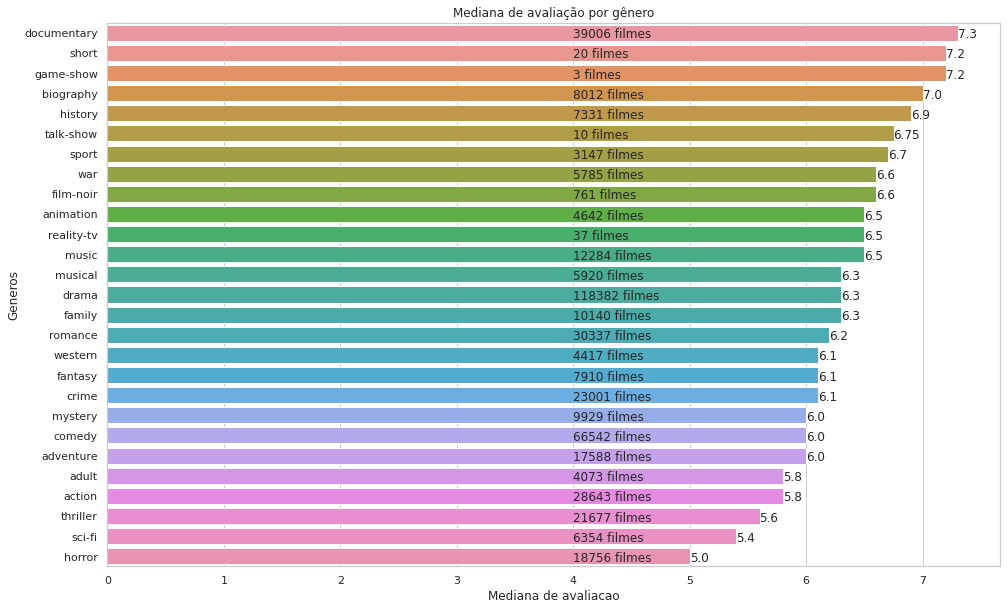

In [76]:
plt.figure(figsize = (16,10))

sns.barplot(y = dfGenerosRating.genres, x = dfGenerosRating.rating, orient = "h")

for i in range(len(dfGenerosRating.index)):
    plt.text(4.0, i + 0.25,str(dfGenerosRating['qtd'][dfGenerosRating.index[i]]) + " filmes")
    plt.text(dfGenerosRating.rating[dfGenerosRating.index[i]], i + 0.25,round(dfGenerosRating['rating'][dfGenerosRating.index[i]],2))

plt.ylabel('Generos')
plt.xlabel('Mediana de avaliacao')
plt.title('Mediana de avaliação por gênero')
plt.show()

# Qual a mediana de avalição dos filmes em relação ao ano de estréia

In [83]:
consulta4 = '''
select
    rating as nota
    , premiered as ano
from 
    ratings
    join titles on ratings.title_id = titles.title_id
where
    premiered <= 2022
    and type = 'movie'
order by
    premiered
'''

In [84]:
resultado4 = pd.read_sql_query(consulta4,conn)

In [85]:
display(resultado4)

,nota,ano
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
266613,4.7,2021
266614,9.6,2021
266615,8.3,2021
266616,5.9,2021


In [86]:
notas = []
for ano in set(resultado4['ano']):
    notas.append(np.median(resultado4[resultado4['ano'] == ano]['nota']))

type(notas)

list

In [93]:
print(len(notas))
notas[1:10]

125


[4.4, 3.8, 6.15, 4.5, 3.5, 4.6, 5.4, 4.3, 3.6]

In [96]:
anos = list(set(resultado4['ano']))
print(len(anos))

125


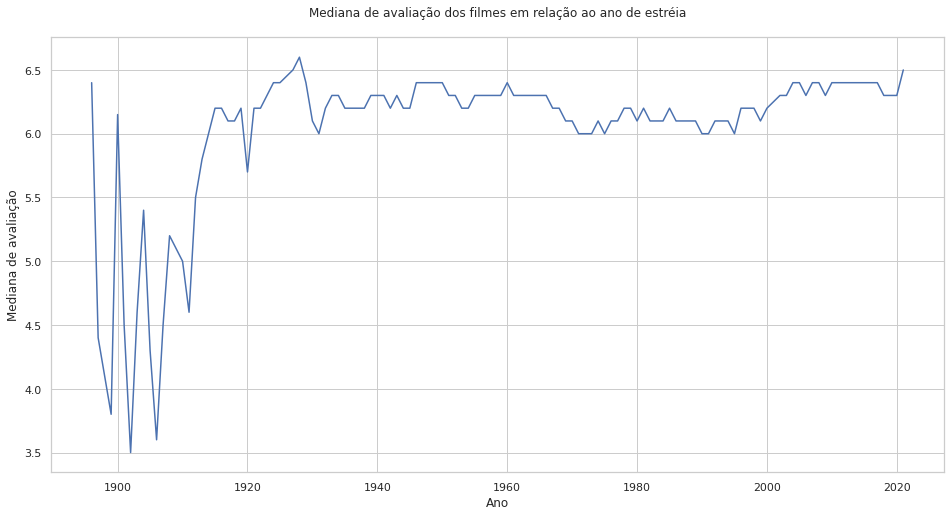

In [99]:
plt.figure(figsize = (16,8))
plt.plot(anos,notas)
plt.xlabel('Ano')
plt.ylabel('Mediana de avaliação')
plt.title('Mediana de avaliação dos filmes em relação ao ano de estréia\n')
plt.show()

# Qual o número de filmes avaliados por gênero em relação ao ano de estréia

In [111]:
consulta5 = '''
select
    genres
from 
    titles
'''

In [112]:
resultado5 = pd.read_sql_query(consulta5,conn)
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8144393,"Action,Drama,Family"
8144394,"Action,Drama,Family"
8144395,"Action,Drama,Family"
8144396,Short


In [113]:
generosUnicos = retorna_generos(resultado5)
generosUnicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [114]:
generoQtd = []

for item in generosUnicos:

    consulta = "select count(*) as qtd from titles where genres like "+"\'%" + item + "%\'"+" and type = 'movie' and premiered <= 2022"
    resultado = pd.read_sql_query(consulta,conn)
    generoQtd.append(resultado['qtd'].values[0])

In [115]:
dfGeneroQtd = pd.DataFrame()
dfGeneroQtd['genero'] = generosUnicos
dfGeneroQtd['qtd'] = generoQtd

In [116]:
dfGeneroQtd = dfGeneroQtd[dfGeneroQtd['genero'] != 'n']
dfGeneroQtd = dfGeneroQtd.sort_values(by = 'qtd', ascending = False)
topGenero = dfGeneroQtd.head()['genero'].values

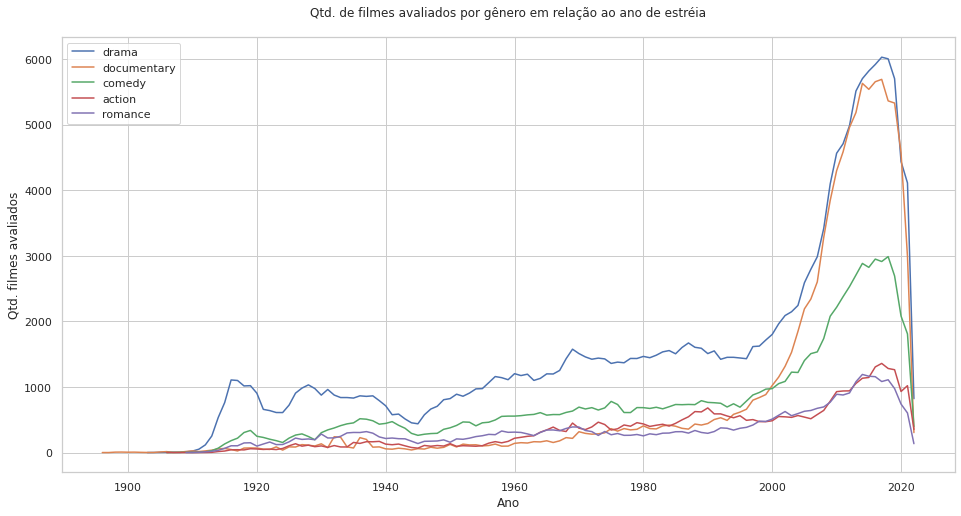

In [118]:
plt.figure(figsize = (16,8))

for item in topGenero:
    consulta = "select count(*) as qtdFilmes, premiered as ano from titles where genres like "+"\'%" + item + "%\'"+" and type = 'movie' and premiered <= 2022 group by ano"
    resultado = pd.read_sql_query(consulta,conn)
    plt.plot(resultado['ano'],resultado['qtdFilmes'])

plt.xlabel('Ano')
plt.ylabel('Qtd. filmes avaliados')
plt.title('Qtd. de filmes avaliados por gênero em relação ao ano de estréia\n')
plt.legend(labels = topGenero)
plt.show()